# Accelerated Convolutional Neural Nets
ECSE 420 Parallel Computing  

Team Members:  
- Anthony Boustany - 260913846  
- Elsa Chelala - 260893285  
- Chad Spector - 260868584  
- Eric Chao - 261121213  

[Here is the Project Write Up](https://docs.google.com/document/d/19fV7zsrxAKer_cHN8ebzFHCE6Wh4qKEHFjYeUaYBQ_w/edit?usp=sharing
)

NOTE: To run this notebook make sure to change the runtime to GPU; otherwise uncomment and run the first cell to enable CUDA Simulator.

Reference Material:
- [Programming Massively Parallel Processors Ch.16](https://learning.oreilly.com/library/view/programming-massively-parallel/9780128119877/xhtml/chp016.xhtml#:-:text=Application%20case%20study%E2%80%94machine,Boris%20Ginsburg)
- [Convolutional Neural Networks](https://en.wikipedia.org/wiki/Convolutional_neural_network)
- [Numba CUDA Reference](https://numba.pydata.org/numba-doc/latest/cuda-reference/)

Enable Cuda Simulator (uncomment):

In [ ]:
# %env NUMBA_ENABLE_CUDASIM=1

In [ ]:
import numpy as np
import pandas as pd
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import time
from typing import List
from tqdm import tqdm
import cv2
import math
import numpy as np
import numba
from numba import cuda
import typing
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

#### Utilities

In [ ]:
def elemWiseDiff(A, B):
    return np.sum(np.abs(A - B))

# CNN Layer Implementations

If we were aiming for a state-of-the-art network or a good classification performance, we would try out different other activation functions and implement an efficient optimization algorithm but that is not the case. <br/>

Our goal is to parallelize the layers of a basic Convolutional Neural Network and obtain a measure of how much more performance speedup we can get, and identify further improvements.

In [ ]:
class Module:
    def __init__(self):
        self.input = None
        self.output = None
        self.size_output = None

    def forward(self, _input, _output):
        raise NotImplementedError()
    def backward(self):
        raise NotImplementedError()
    def update(self):
        pass

## Linear Layer + ReLU

All layers implement two methods:
- `forward`: compute output feature from the input feature map received from previous layer
- `backward`: compute the gradient of loss with respect to the layer's inputs, given the gradient of next layer
- `update`: compute the gradient of loss with respect to the layer's parameters, and use it to update the weights with a learning rate

#### Linear Layer CPU

In [ ]:
class Linear_CPU(Module):
    def __init__(self, bs: int, n_in: int, n_out: int, lr: float = 0.1):
        self.bs = bs    # batch size or n observations
        self.n_in = n_in
        self.n_out = n_out
        self.lr = lr

        self.size_weights = n_in * n_out
        self.out_size = bs * n_out

        # Initialize weights and biases
        kaiming = math.sqrt(2/self.n_in) # std deviation for kaiming initialization
        self.weights = np.random.normal(loc=0, scale=kaiming, size=self.size_weights)
        self.bias = np.zeros(self.n_out)
        self.cp_weights = None # for back pass

    def forward(self, X, Y, use_np=False):
        # Matrix multiplication:  input[row,:] * weight[:,col] -> out[row, col]
        for i in range(0, self.bs): # for every observation
            for k in range(0, self.n_out):
                # Y[i][k]
                y_i = i*self.n_out + k
                # Add bias
                Y[y_i] = self.bias[k]
                # Y[y_i] stores the dot product of row X[i,:] and col W[:,j]
                for j in range(0, self.n_in):
                    x_i = i*self.n_in + j
                    w_i = j * self.n_out + k
                    Y[y_i] += X[x_i] * self.weights[w_i]
        # Save pointers after forward pass
        self.X = X
        self.out = Y
        return

    def update(self):
        '''
        Create a copy of the weights because the next
        step in the algorithm (backward pass)
        requires the weights before being updated.
        We then delete cp weights after no longer needed
        (see .backward)
        '''
        self.cp_weights = self.weights.copy()
        self._linear_update_cpu()
        return

    def backward(self):
        '''
        Compute gradient of Loss wrt layer's input X.
        Y contains gradient of Loss wrt layer's output Y.
        On a backward pass, gradients are now stored in X
        Typically, libraries keep the gradient in a different data structure, e.g. X.grad
        Assumes self.cp_weights holds a copy of weights before .update()
        '''
        X = np.zeros(self.bs * self.n_in)

        for i in range(self.bs):
            for k in range(self.n_out):
                y_i = i * self.n_out + k

                for j in range(self.n_in):
                    x_i = i * self.n_in + j
                    w_i = j * self.n_out + k
                    # Essentially multiply Out w/ Weights_transpose
                    X[x_i] += self.cp_weights[w_i] * self.out[y_i]
        
        self.X = X # update data X for next layer (gradients); could use another attr but its fine for now
        self.cp_weights = None # don't need anymore
        return

    def _linear_update_cpu(self):
        '''
        Y contains gradient dL/dY_pred
        X is the original input to the layer
        Update should be performed after backward pass 
        of the next layer in the arch, 
        and before backward pass of this layer
        '''
        for i in range(self.bs):
            for k in range(self.n_out):
                # output[i][k]
                y_i = i * self.n_out + k
                # update bias term
                self.bias[k] -= self.lr * self.out[y_i]
                for j in range(self.n_in):
                    x_i = i * self.n_in + j
                    w_i = j* self.n_out + k
                    self.weights[w_i] -= self.lr * (self.X[x_i]*self.out[y_i])

#### Linear Layer GPU

In [ ]:
from numba import cuda

@cuda.jit
def linear_forward_gpu(X, weights, bias, Y, bs, n_in, n_out):
    # Implements matrix multiplication of bs observations
    row = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x # i-th input
    col = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y # j-th output

    if (row < bs and col < n_out):
        y_i = row * n_out + col
        Y[y_i] = bias[col]

        for i in range(0, n_in): # for every input unit
            x_i = row * n_in + i
            w_i = i * n_out + col
            Y[y_i] += X[x_i] * weights[w_i]

In [ ]:
@cuda.jit
def linear_backward_gpu(X, weights, Y, bs, n_in, n_out):
    row = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x # i-th input
    col = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y # j-th output

    if (row < bs and col < n_out):
        y_i = row * n_out + col

        for i in range(n_in):
            x_i = row * n_in + i
            w_i = i * n_out + col
            cuda.atomic.add(X, x_i, weights[w_i] * Y[y_i])


In [ ]:
@cuda.jit
def linear_update_gpu(X, weights, bias, Y, bs, n_in, n_out, lr):
    row = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    col = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y

    if row < bs and col < n_out: # within dimensions of output matrix
        y_i = row * n_out + col
        cuda.atomic.add(bias, col, -lr * Y[y_i])

        for i in range(n_in):
            x_i = row * n_in + i
            w_i = i * n_out + col

            cuda.atomic.add(weights, w_i,-lr*X[x_i] * Y[y_i])

In [ ]:
class Linear_GPU(Module):
    BLOCK_SIZE = 32

    def __init__(self, bs, n_in, n_out, lr=0.1):
        self.bs = bs    # batch size or n observations
        self.n_in = n_in
        self.n_out = n_out
        self.lr = lr
        self.size_weights = n_in * n_out
        self.out_size = bs * n_out

        self.cp_weights = None

        # Initialize weights and biases
        kaiming = math.sqrt(2/self.n_in) # std deviation for kaiming initialization
        self.weights = np.random.normal(loc=0, scale=kaiming, size=self.size_weights)
        self.bias = np.zeros(self.n_out)
        
        # Block dimensions (threads per block) depend on batch size and outputs
        self.n_block_rows = math.ceil( self.bs / self.BLOCK_SIZE) #(self.bs + self.BLOCK_SIZE - 1) // self.BLOCK_SIZE
        self.n_block_cols = math.ceil( self.n_out / self.BLOCK_SIZE) #(self.n_out + self.BLOCK_SIZE - 1) // self.BLOCK_SIZE
        return
    
    def forward(self, X, Y):
        gridDim = (self.n_block_rows, self.n_block_cols)
        blockDim = (self.BLOCK_SIZE, self.BLOCK_SIZE)
        linear_forward_gpu[gridDim, blockDim](X, self.weights, self.bias, Y, self.bs, self.n_in, self.n_out)
        # Wait for gpu to finish
        cuda.synchronize()
        # Save pointers after forward pass
        self.X = X
        self.out = Y
        return

    def update(self):
        self.cp_weights = self.weights.copy()
        n_blocks = (self.n_block_rows, self.n_block_cols)
        threads_block = (self.BLOCK_SIZE, self.BLOCK_SIZE)
        # X, weights, bias, Y, bs, n_in, n_out
        linear_update_gpu[n_blocks, threads_block](self.X, self.weights, self.bias, self.out, self.bs, self.n_in, self.n_out, self.lr)
        cuda.synchronize()
        return
    
    def backward(self):
        self.X = np.zeros(self.bs * self.n_in)
        gridDim = (self.n_block_rows, self.n_block_cols)
        blockDim = (self.BLOCK_SIZE, self.BLOCK_SIZE)

        linear_backward_gpu[gridDim, blockDim](self.X, self.cp_weights, self.out, self.bs, self.n_in, self.n_out)
        cuda.synchronize()
        return

    def setBlockSize(self, size):
        self.BLOCK_SIZE = size
        # Block dimensions (threads per block) depend on batch size and outputs
        self.n_block_rows = (self.bs + self.BLOCK_SIZE - 1) // self.BLOCK_SIZE
        self.n_block_cols = (self.n_out + self.BLOCK_SIZE - 1) // self.BLOCK_SIZE

#### Relu Layer CPU

In [ ]:
class ReLU_CPU(Module):
    def __init__(self, out_size):
        self.out_size = out_size
        return
    
    def forward(self, X, Y):
        # Write out to Y array
        Y[:] = np.maximum(0, X)
        self.out = Y
    
    def backward(self):
        # self.out should be computed in forward pass
        self.X = np.where(self.out > 0, 1.0, 0.0)

#### Relu Layer GPU

In [ ]:
@cuda.jit
def relu_forward_gpu(X, Y, out_size):
    ind = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    if ind < out_size:
        Y[ind] = max(0, X[ind])

In [ ]:
@cuda.jit
def relu_backward_gpu(X, Y, out_size):
    # Store the derivative of relu in X
    ind = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    if ind < out_size:
        X[ind] = 1.0 if Y[ind] > 0 else 0.0

In [ ]:
class ReLU_GPU(Module):
    BLOCK_SIZE = 32
    def __init__(self, out_size):
        self.out_size = out_size
        self.n_blocks = (out_size + self.BLOCK_SIZE - 1) // self.BLOCK_SIZE
        return

    def forward(self, X, Y):
        relu_forward_gpu[self.n_blocks, self.BLOCK_SIZE](X, Y, self.out_size)
        cuda.synchronize()
        self.out = Y # keep a pointer for later
        return
    
    def backward(self):
        self.X = np.zeros(self.out_size)
        relu_backward_gpu[self.n_blocks, self.BLOCK_SIZE](self.X, self.out, self.out_size)
        cuda.synchronize()
        return

#### Sequential Model

This container class is used to integrate the layers in a Neural Network.
- On a forward pass, we traverse through the layers, calling `forward` on each one and passing the output of a layer in Y as input to the next
- On a backward pass, we traverse the layers from back to front, calling `update` and then `backward` on each of them, passing the output in X of each layer as input to the previous layer

In [ ]:
class Sequential_CPU(Module):
    def __init__(self, layers):
        # Layers is a list of Module objects (vector of pointers)
        self.layers=layers

    def forward(self, X, Y):
        for i, layer in enumerate(self.layers):
            out_size = layer.out_size
            curr_Y = np.zeros(out_size)
            layer.forward(X, curr_Y)
            
            X = curr_Y
        # In the end, output is kept in last_layer->out
        self.out = X # could also work

    # There is no .backward method, only update
    def update(self):
        for layer in self.layers[::-1]:
            layer.update()
            layer.backward()

#### Sequential Model GPU

In [ ]:
class Sequential_GPU(Module):
    '''
    Practically identical to Sequential_CPU.
    There is nothing to parallelize, but if using
    CUDA we would need to allocate GPU memory with
    cudaMalloc API on every layer forward pass.
    '''
    def __init__(self, layers):
        self.layers=layers

    def forward(self, X, Y):
        for i,layer in enumerate(self.layers):
            # If using CUDA we would use cudaMallocManaged
            out_size = layer.out_size
            curr_Y = np.zeros(out_size)
            layer.forward(X, curr_Y)
            
            X = curr_Y

        self.out = X      # In CUDA we would also finally cudaFree(curr_Y)
    
    # There is no .backward method, only update
    def update(self):
        for i,layer in enumerate(self.layers):
            layer.update()
            layer.backward()

#### MSE CPU
This layer is used as an artificial last layer to a Sequential Model container to compute the value of Loss function on forward pass and the gradient of Loss with respect to predictions on backward pass.

In [ ]:
class MSE_CPU(Module):
    '''
    Loss function of our choice is Mean Squared Error.
    Follows the Module interface for consistency.
    '''
    def __init__(self, out_size):
        self.out_size=out_size

    def forward(self, Y_pred, Y_true):
        # Don't calculate Loss
        self.Y_pred = Y_pred
        self.Y_true = Y_true

    def _forward(self):
        # Do calculate Loss at Y_true[-1]
        if len(self.Y_true) < self.out_size + 1:
            print(f"Please allow an extra space in self.Y_true; ({len(self.Y_true)}) vs ({self.out_size+1}) lengths",)
        self.Y_true[self.out_size] = 0.0
        mse = ((self.Y_pred - self.Y_true[:self.out_size]) ** 2).mean() # both 1-dimensional
        self.Y_true[self.out_size] = mse

    def backward(self):
        # Derivative of Loss wrt our Model's output (this layer's input)
        # Store the derivative in the input array Y_pred
        self.Y_pred[:] = (2./self.out_size) * (self.Y_pred - self.Y_true[:self.out_size])

#### MSE GPU

In [ ]:
@cuda.jit
def mse_forward_gpu(X, Y, out_size):
    # Y is out_size+1
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    if i < out_size:
        cuda.atomic.add(Y, out_size, ((X[i] - Y[i]) ** 2) / out_size )

In [ ]:
@cuda.jit
def mse_backward_gpu(X, Y, out_size):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    if i < out_size:
        X[i] = (2./out_size) * (X[i] - Y[i])

In [ ]:
class MSE_GPU(Module):
    BLOCK_SIZE = 32
    def __init__(self, out_size):
        self.out_size = out_size
        self.n_blocks = (out_size + self.BLOCK_SIZE - 1) // self.BLOCK_SIZE

    def forward(self, Y_pred, Y_true):
        # Don't calculate Loss, only store references for back pass
        self.Y_pred = Y_pred
        self.Y_true = Y_true

    def _forward(self):
        if len(self.Y_true) < self.out_size + 1:
            print(f"Please allow an extra space in self.Y_true; ({len(self.Y_true)}) vs ({self.out_size+1}) lengths",)

        self.Y_true[self.out_size] = 0.0
        mse_forward_gpu[self.n_blocks, self.BLOCK_SIZE](self.Y_pred, self.Y_true, self.out_size)
        # MSE is stored in last Y_true[out_size]
        cuda.synchronize()
        return

    def backward(self):
        mse_backward_gpu[self.n_blocks, self.BLOCK_SIZE](self.Y_pred, self.Y_true, self.out_size)
        cuda.syncrhonize()

## Convolution & Pooling Layers

#### Convolution CPU

In [ ]:
from tqdm import tnrange
class Convolution_CPU(Module):
    '''
    Works with M channels (input matrices) and square filters (K*K)
    '''
    def __init__(self, bs: int, n_in: int, n_out: int, k: int, h: int, w: int, lr: float = 0.1, flat=True):
        self.N=bs
        self.n_in=n_in
        self.n_out=n_out
        self.lr=lr
        self.K = k        # kernel dimensions
        self.C = n_in     # input maps C
        self.M = n_out    # output maps M
        self.H = h        # input map height
        self.W = w        # input map width
        # Weights is a flat matrix dimensions M*C*K*K
        if flat:
            self.weights = np.zeros(self.M * self.C * k * k)
        else:
            scale = math.sqrt(2./(h * w))
            self.weights = np.random.normal(loc=0, scale=scale, size=(self.M, self.C, self.K, self.K))

    def forward(self, X, Y):
        # M output maps
        # C input maps
        # H, W are height and width of input feature maps C
        H_out = self.H - self.K + 1
        W_out = self.W - self.K + 1
        elems_out = H_out * W_out
        
        for obs in tnrange(self.N, desc="Observations"):    # for every observation in data set
            for m in range(self.M):  # for every output map
                # for every output pixel i,j
                for i in range(H_out):
                    for j in range(W_out):
                        # for every input map (channel)
                        for c in range(self.C):
                            # for every position in the kernel
                            for p in range(self.K):
                                for q in range(self.K):
                                    Y[obs,m,i,j] += X[obs, c, i+p, j+q] * self.weights[m, c, p, q]

        self.X=X
        self.Y=Y

    def backward(self, dE_dY):
        # Receives gradient of next layer dE_dY
        # Computes the gradient of Loss with respect to layer's weights
        # dE_dY has dimensions M*C*H_out*W_out
        H_out = self.H - self.K + 1
        W_out = self.W - self.K + 1
        dE_dW = np.zeros(self.M * self.C * self.K * self.K)
        # TODO: Add another dimension to X (N arrays, N observations)
        for m in range(self.M):
            for c in range(self.C):
                for i in range(H_out):
                    for j in range(W_out):
                        for p in range(self.K):
                            for q in range(self.K):
                                dw_i = m*(self.C*self.K*self.K) + c*(self.K*self.K) + p*self.K + q 
                                x_i = c*(self.K*self.K) + (i+p)*self.K + (j+q)
                                dy_i = m*(self.C*H_out*W_out) + c*(H_out*W_out) + i*W_out + j

                                dE_dW[dw_i] += X[x_i] * dE_dY[dy_i]
        # Store pointer to results
        self.dE_dW = dE_dW

    def update(self):
        pass

#### Convolution GPU

In [ ]:
'''
Straightforward parallel implementation has high parallelization
but also high levels of global memory consumption.
Execution speed is then limited by global memory bandwidth.
We could reduce traffic and thus bandwidth by using efficient Memory Tiling.
For now, we write a global memory solution for correctness.
'''
@cuda.jit
def convolution_forward_gpu(C, W_grid, K, X, W, Y, H_out, W_out):
    # We split a single output map work in tiles, with a 2d block
    # computing TILE_WIDTH x TILE_HEIGHT pixels of one output matrix.
    # To do for N observations we launch NxM blocks
    # Each thread loops over the C input channels since all inputs
    # influence the value of a single output pixel.

    n = cuda.blockIdx.x    # gives index in mini batch
    m = cuda.blockIdx.y    # gives output map index
    
    # Z dimension define the location of the output tile inside the output feature map.
    tile_i = cuda.blockIdx.z // W_grid
    i = tile_i*cuda.blockDim.y + cuda.threadIdx.y  
    tile_j = cuda.blockIdx.z % W_grid
    j = tile_j*cuda.blockDim.x + cuda.threadIdx.x

    if i < H_out and j < W_out:
        wSum = 0.
        # for every input channel
        for c in range(C):
            # Convolve W on X
            for p in range(K):
                for q in range(K):
                    wSum += (X[n, c, i+p, j+q] * W[m,c,p,q])

        Y[n, m, i, j] = wSum


In [ ]:
import math
class Convolution_GPU(Module):
    '''
    Works with M channels (input matrices) and square filters (K*K)
    '''
    TILE_SIZE = 16 # dimensions of block to launch

    def __init__(self, bs: int, n_in: int, n_out: int, k: int, h: int, w: int, lr: float = 0.1, flat=True):
        self.N=bs # can only handle 1 for now
        self.lr=lr
        self.K = k        # kernel dimensions
        self.C = n_in     # input maps C
        self.M = n_out    # output maps M
        self.H = h        # input map height
        self.W = w        # input map width

        # Weights is a flat matrix dimensions M*C*K*K
        if flat:
            self.weights = np.zeros(self.M * self.C * k * k)
        else:
            scale = math.sqrt(2./(h * w))
            self.weights = np.random.normal(loc=0, scale=scale, size=(self.M, self.C, self.K, self.K))
    
    def forward(self, X, Y):
        H_out = self.H - self.K + 1
        W_out = self.W - self.K + 1

        # Tile the output grid
        W_grid = math.ceil( W_out / self.TILE_SIZE)
        H_grid = math.ceil(H_out / self.TILE_SIZE)
        
        # Extra tiles if dimensions not multiples of tile width
        Z = H_grid * W_grid # total number of tiles in output Y

        blockDim = (self.TILE_SIZE, self.TILE_SIZE, 1) # square tiles
        gridDim = (self.N, self.M, Z)

        convolution_forward_gpu[gridDim, blockDim](self.C, W_grid, self.K, X, self.weights, Y, H_out, W_out)
        cuda.synchronize()

        self.X=X
        self.Y=Y

    def setTileSize(self, size):
        self.TILE_SIZE = size

###Pooling CPU

In [ ]:
import math
from tqdm import tnrange

def sigmoid(x):
        return 1/(1+math.exp(-x))


class Pooling_CPU(Module):
    '''
    Works with M channels (input matrices) and square filters (K*K)
    '''


    def __init__(self, bs: int, n_in: int, n_out: int, k: int, h: int, w: int, lr: float = 0.1, flat=True):
        self.N=bs
        self.n_in=n_in
        self.n_out=n_out
        self.lr=lr
        self.K = k        # kernel dimensions
        self.C = n_in     # input maps C
        self.M = n_out    # output maps M
        self.H = h        # input map height
        self.W = w        # input map width


    def forward(self, Y, S):
       
        for obs in tnrange(self.N, desc="Observations"):    # for every observation in data set
            for m in range(self.M):  # for every output map
                # for every output pixel i,j
                for i in range(self.H//self.K):
                    for j in range(self.W//self.K):
                            #S[obs,m,i,j] = 0.
                            # for every position in the kernel
                            for p in range(self.K):
                                for q in range(self.K):
                                    S[obs,m,i,j] += Y[obs, m, self.K*i + p, self.K*j + q]/(self.K*self.K)

              
        self.S=S
        self.Y=Y

    

###Pooling GPU

In [ ]:
import math
    

@cuda.jit
def poolingLayer_forward_gpu(W_grid, H, W, K, Y, S):
    # We split a single output map work in tiles, with a 2d block
    # computing TILE_WIDTH x TILE_HEIGHT pixels of one output matrix.
    # To do for N observations we launch NxM blocks
    # Each thread loops over the C input channels since all inputs
    # influence the value of a single output pixel.

    def sigmoid(x):
        return 1/(1+math.exp(-x))

    n = cuda.blockIdx.x    # gives index in mini batch
    m = cuda.blockIdx.y    # gives output map index
    
    # Z dimension define the location of the output tile inside the output feature map.
    tile_i = cuda.blockIdx.z // W_grid
    i = tile_i*cuda.blockDim.y + cuda.threadIdx.y  
    tile_j = cuda.blockIdx.z % W_grid
    j = tile_j*cuda.blockDim.x + cuda.threadIdx.x

    sum = 0.

    if (i < H//K) and (j < W//K):
        for p in range(K):
            for q in range(K):
                sum += Y[n, m, K*i + p, K*j + q]/(K*K)
        S[n,m,i,j] = sum

        
      
      


In [ ]:
import math
class Pooling_GPU(Module):
    '''
    Works with M channels (input matrices) and square filters (K*K)
    '''
    TILE_WIDTH = 16 # dimensions of block to launch

    def __init__(self, bs: int, n_in: int, n_out: int, k: int, h: int, w: int, lr: float = 0.1, flat=True):
        self.N=bs # can only handle 1 for now
        self.lr=lr
        self.K = k        # kernel dimensions
        self.C = n_in     # input maps C
        self.M = n_out    # output maps M
        self.H = h        # input map height
        self.W = w        # input map width

    def slider(self, inp):
      '''
      Sliding generator that yields areas for max pooling.
      '''
      output_size = int(self.W / self.K)  # Assume S = K

      for h_idx in range(self.K):
          for w_idx in range(self.K):
              single_slide_area = inp[h_idx * self.k:h_idx * self.k + self.k,
                                        w_idx * self.k:w_idx * self.k + self.k]
              yield single_slide_area, h_idx, w_idx
    
    def forward(self, Y, S):

        H_out = self.H - self.K + 1
        W_out = self.W - self.K + 1

        # Tile the output grid
        W_grid = math.ceil(self.W / self.TILE_WIDTH)
        H_grid = math.ceil(H_out / self.TILE_WIDTH)
        
        # Extra tiles if dimensions not multiples of tile width
        Z = self.H * self.W # total number of tiles in output Y

        blockDim = (self.TILE_WIDTH, self.TILE_WIDTH, 1) # square tiles
        gridDim = (self.N, self.M, Z)

        poolingLayer_forward_gpu[gridDim, blockDim](W_grid, self.H, self.W, self.K, Y, S)
        cuda.synchronize()

        self.S=S
        self.Y=Y
      
    def setTileSize(self, size):
        self.TILE_WIDTH = size
    
    


# Performance Experiments


In [ ]:
numba.cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-18a38eb8-18b3-52a6-bc0a-dfa87d262d65
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

## Forward pass with Fashion-MNIST

### Load Fashion-MNIST Data


----FINISHED DOWNLOAD
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


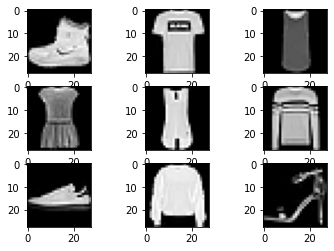

In [ ]:
from keras.datasets import fashion_mnist
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
# summarize loaded dataset
print("\n----FINISHED DOWNLOAD")
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [ ]:
# NORMALIZED DATA
# Normalize the data into (-1, 1) range
# normalize(x) <- x - min(X) / (max(X) - min(X)) = x / 255

normalTrainX = (2.*trainX/255) - 1
normalTestX = (2.*testX/255) - 1

### Convolution (correctness): CPU vs GPU

In [ ]:
# --- SETUP
X_data = normalTrainX[:,None,:,:]    # (60000, 1, 28, 28)
# _X_data = X_data[:10] # testing

N, C, H, W = X_data.shape
K = 2
H_out = H - K + 1
W_out = W - K + 1
M = 1

# --- CPU SETUP
# Allocate for Y
Y_cpu = np.zeros((N, M, H_out, W_out))
# Y_gpu = np.zeros((N, M, H_out, W_out))
conv_cpu = Convolution_CPU(bs=N, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)

# --- GPU SETUP
Y_gpu = np.zeros((N, M, H_out, W_out))
conv_gpu = Convolution_GPU(bs=N, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)
conv_gpu.weights = conv_cpu.weights.copy()


CPU

In [ ]:
# --- START TIMER
tic = time.perf_counter()

# --- Forward Pass
conv_cpu.forward(X_data, Y_cpu)

# --- STOP TIMER
toc = time.perf_counter()
# --- PRINT TIMER
exec_time_cpu = toc - tic
print(f"[Sequential, tiled execution finished in {exec_time_cpu:0.5f} seconds]") 

Observations:   0%|          | 0/60000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

GPU <br/> 
*make sure `NUMBA_ENABLE_CUDASIM` flag is disabled*


In [ ]:
# --- START TIMER
tic = time.perf_counter()

# --- Forward Pass
print("shape", X_data.shape)
conv_gpu.forward(X_data, Y_gpu)

# --- STOP TIMER
toc = time.perf_counter()
# --- PRINT TIMER
exec_time_gpu = toc - tic
print(f"[Parallel, tiled execution finished in {exec_time_gpu:0.5f} seconds]") 

In [ ]:
# Compute Average Element-wise Difference
MeanDiff = elemWiseDiff(Y_cpu, Y_gpu) / Y_cpu.size
MeanDiff

### Convolution Results + Plots

#### Speedup with Block Size = 16

In [ ]:
MAX_N = normalTrainX.shape[0]
INP_SIZES = [10, 100, 1000, 5000, 10000, 20000, 60000]
X = normalTrainX[:,None,:,:]

times_cpu = []
times_gpu = []

for input_size in INP_SIZES:
    print("=> Input size", input_size)
    subset_X = X[:input_size]     # (size, 1, 28, 28)
    # Setup
    N, C, H, W = subset_X.shape
    K = 2
    H_out = H - K + 1
    W_out = W - K + 1
    M = 1
    # --- SETUP
    Y_cpu = np.zeros((input_size, M, H_out, W_out))
    Y_gpu = np.zeros((input_size, M, H_out, W_out))
    conv_cpu = Convolution_CPU(bs=input_size, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)
    conv_gpu = Convolution_GPU(bs=input_size, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)
    conv_gpu.weights = conv_cpu.weights.copy()

    # CPU
    # --- START TIMER
    tic = time.perf_counter()

    # --- Forward Pass
    conv_cpu.forward(subset_X, Y_cpu)
    # --- STOP TIMER
    toc = time.perf_counter()
    # --- PRINT TIMER
    exec_time_cpu = toc - tic

    # GPU
    # --- START TIMER
    tic_ = time.perf_counter()
    # --- Forward Pass
    conv_gpu.forward(subset_X, Y_gpu)

    # --- STOP TIMER
    toc_ = time.perf_counter()
    # --- PRINT TIMER
    exec_time_gpu = toc_ - tic_

    times_cpu.append(exec_time_cpu)
    times_gpu.append(exec_time_gpu)
    print("finished\t", "(cpu)",exec_time_cpu,"\t(gpu)", exec_time_gpu)
    print("Mean Element wise Delta in Y results", elemWiseDiff(Y_cpu, Y_gpu) / (Y_cpu.size))

=> Input size 10


Observations:   0%|          | 0/10 [00:00<?, ?it/s]

finished	 (cpu) 0.12535611599997765 	(gpu) 1.8529053039999894
Mean Element wise Delta in Y results 1.5389517369885852e-18
=> Input size 100


Observations:   0%|          | 0/100 [00:00<?, ?it/s]

finished	 (cpu) 0.3986166619999949 	(gpu) 0.02261856800004125
Mean Element wise Delta in Y results 7.413144746298001e-19
=> Input size 1000


Observations:   0%|          | 0/1000 [00:00<?, ?it/s]

finished	 (cpu) 7.15533304500002 	(gpu) 0.3420882449999567
Mean Element wise Delta in Y results 1.3924420886655436e-18
=> Input size 5000


Observations:   0%|          | 0/5000 [00:00<?, ?it/s]

finished	 (cpu) 23.19590337400001 	(gpu) 1.8759247980000282
Mean Element wise Delta in Y results 9.667971334934161e-19
=> Input size 10000


Observations:   0%|          | 0/10000 [00:00<?, ?it/s]

finished	 (cpu) 38.189547284000014 	(gpu) 1.278464272000008
Mean Element wise Delta in Y results 1.0094451465808658e-18
=> Input size 20000


Observations:   0%|          | 0/20000 [00:00<?, ?it/s]

finished	 (cpu) 79.40233184600004 	(gpu) 2.5073027789999855
Mean Element wise Delta in Y results 1.4049525708848488e-18
=> Input size 60000


Observations:   0%|          | 0/60000 [00:00<?, ?it/s]

finished	 (cpu) 213.65028019500005 	(gpu) 7.443217105000031
Mean Element wise Delta in Y results 1.0281431656282359e-18


In [ ]:
times_cpu

[0.12535611599997765,
 0.3986166619999949,
 7.15533304500002,
 23.19590337400001,
 38.189547284000014,
 79.40233184600004,
 213.65028019500005]

In [ ]:
times_gpu

[1.8529053039999894,
 0.02261856800004125,
 0.3420882449999567,
 1.8759247980000282,
 1.278464272000008,
 2.5073027789999855,
 7.443217105000031]

Max Speedup obtained 31.66842573263885


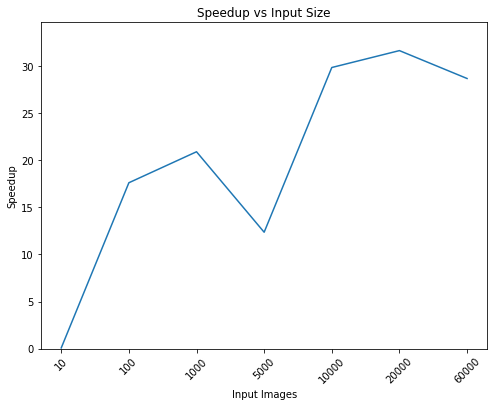

In [ ]:
speedup = [seq / pall for (seq, pall) in zip(times_cpu, times_gpu)]
max_speedup = np.max(speedup)
print("Max Speedup obtained", max_speedup)
x_ticks = [i for i in range(1,len(speedup)+1)]
plt.figure(figsize=(8,6))
plt.plot(x_ticks, speedup)
plt.xticks(x_ticks, INP_SIZES, rotation='45')

plt.ylabel('Speedup')
plt.xlabel('Input Images')
plt.ylim(0, max_speedup+3)
plt.title('Speedup vs Input Size')
plt.savefig('speedup_inputsize', dpi=300)


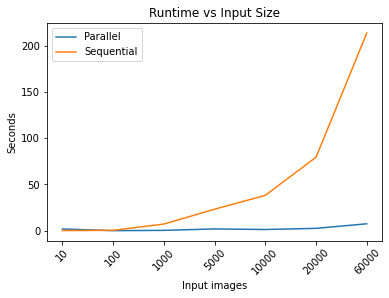

In [ ]:
plt.clf()
plt.plot(x_ticks, times_gpu, label="Parallel")
plt.plot(x_ticks, times_cpu, label="Sequential")
plt.xticks(x_ticks, INP_SIZES, rotation='45')
plt.xlabel("Input images")
plt.ylabel("Seconds")
plt.legend()
plt.title("Runtime vs Input Size")

plt.savefig("runtime_inputsize", dpi=300)

#### Speedup with Block Size = 24

In [ ]:
MAX_N = normalTrainX.shape[0]
INP_SIZES = [10, 100, 1000, 5000, 10000, 20000, 60000]
X = normalTrainX[:,None,:,:]
TILE_SIZE = 24

times_cpu_24 = []
times_gpu_24 = []

for input_size in INP_SIZES:
    print("=> Input size", input_size)
    subset_X = X[:input_size]     # (size, 1, 28, 28)
    # Setup
    N, C, H, W = subset_X.shape
    K = 2
    H_out = H - K + 1
    W_out = W - K + 1
    M = 1
    # --- SETUP
    Y_cpu = np.zeros((input_size, M, H_out, W_out))
    Y_gpu = np.zeros((input_size, M, H_out, W_out))
    conv_cpu = Convolution_CPU(bs=input_size, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)
    conv_gpu = Convolution_GPU(bs=input_size, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)
    conv_gpu.weights = conv_cpu.weights.copy()
    
    conv_gpu.setTileSize(TILE_SIZE)

    # CPU
    # --- START TIMER
    tic = time.perf_counter()

    # --- Forward Pass
    conv_cpu.forward(subset_X, Y_cpu)
    # --- STOP TIMER
    toc = time.perf_counter()
    # --- PRINT TIMER
    exec_time_cpu = toc - tic

    # GPU
    # --- START TIMER
    tic_ = time.perf_counter()
    # --- Forward Pass
    conv_gpu.forward(subset_X, Y_gpu)

    # --- STOP TIMER
    toc_ = time.perf_counter()
    # --- PRINT TIMER
    exec_time_gpu = toc_ - tic_

    times_cpu_24.append(exec_time_cpu)
    times_gpu_24.append(exec_time_gpu)
    print("finished\t", "(cpu)",exec_time_cpu,"\t(gpu)", exec_time_gpu)
    print("Mean Element wise Delta in Y results", elemWiseDiff(Y_cpu, Y_gpu) / (Y_cpu.size))

=> Input size 10


Observations:   0%|          | 0/10 [00:00<?, ?it/s]

finished	 (cpu) 0.1336536060000526 	(gpu) 1.2542054729999563
Mean Element wise Delta in Y results 2.4915763241407316e-18
=> Input size 100


Observations:   0%|          | 0/100 [00:00<?, ?it/s]

finished	 (cpu) 0.37372692100007043 	(gpu) 0.019228200000043216
Mean Element wise Delta in Y results 1.0288188389907516e-18
=> Input size 1000


Observations:   0%|          | 0/1000 [00:00<?, ?it/s]

finished	 (cpu) 3.387651051000148 	(gpu) 0.1402510830000665
Mean Element wise Delta in Y results 3.022239185739321e-18
=> Input size 5000


Observations:   0%|          | 0/5000 [00:00<?, ?it/s]

finished	 (cpu) 17.9753527150001 	(gpu) 0.6534986130000107
Mean Element wise Delta in Y results 7.237780886114928e-19
=> Input size 10000


Observations:   0%|          | 0/10000 [00:00<?, ?it/s]

finished	 (cpu) 47.75625379000007 	(gpu) 1.2501411519999692
Mean Element wise Delta in Y results 1.0258085592329323e-18
=> Input size 20000


Observations:   0%|          | 0/20000 [00:00<?, ?it/s]

finished	 (cpu) 65.42148739799995 	(gpu) 2.4791293719999885
Mean Element wise Delta in Y results 9.863690509686454e-19
=> Input size 60000


Observations:   0%|          | 0/60000 [00:00<?, ?it/s]

finished	 (cpu) 199.98820477999993 	(gpu) 7.334483890000001
Mean Element wise Delta in Y results 1.6785501368582855e-18


In [ ]:
times_cpu_24

[0.07641962399975455,
 0.3951007700002265,
 4.0552066600002945,
 22.662117108000075,
 36.43767107599979,
 73.29506117000028,
 214.65610563100017]

In [ ]:
times_gpu_24

[0.009133527000358299,
 0.020787155000107305,
 0.23518194799999037,
 0.5928772040001604,
 1.1876037050001287,
 2.4064873490001446,
 7.296861977999924]

Max Speedup obtained 38.22396434725114


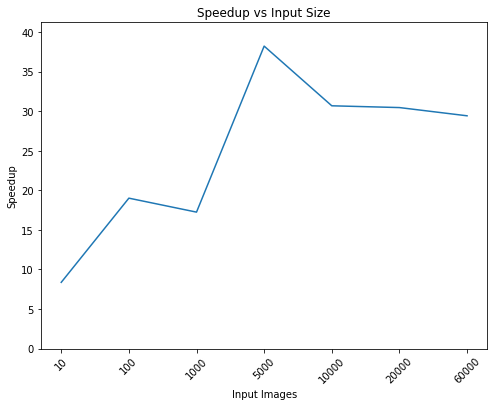

In [ ]:
speedup = [seq / pall for (seq, pall) in zip(times_cpu_24, times_gpu_24)]
max_speedup = np.max(speedup)
print("Max Speedup obtained", max_speedup)
x_ticks = [i for i in range(1,len(speedup)+1)]
plt.figure(figsize=(8,6))
plt.plot(x_ticks, speedup)
plt.xticks(x_ticks, INP_SIZES, rotation='45')

plt.ylabel('Speedup')
plt.xlabel('Input Images')
plt.ylim(0, max_speedup+3)
plt.title('Speedup vs Input Size')
plt.savefig('speedup_inputsize', dpi=300)


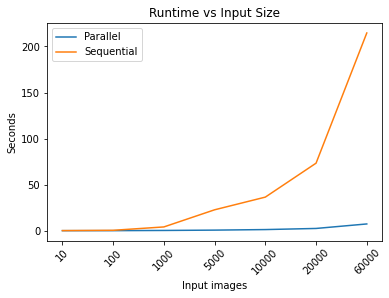

In [ ]:
plt.clf()
plt.plot(x_ticks, times_gpu_24, label="Parallel")
plt.plot(x_ticks, times_cpu_24, label="Sequential")
plt.xticks(x_ticks, INP_SIZES, rotation='45')
plt.xlabel("Input images")
plt.ylabel("Seconds")
plt.legend()
plt.title("Runtime vs Input Size")

plt.savefig("runtime_inputsize", dpi=300)

In [ ]:
np.max(speedup)

38.22396434725114

#### Speedup with Block Size = 32

In [ ]:
MAX_N = normalTrainX.shape[0]
INP_SIZES = [10, 100, 1000, 5000, 10000, 20000, 60000]
X = normalTrainX[:,None,:,:]
TILE_SIZE = 32

times_cpu_32 = []
times_gpu_32 = []

for input_size in INP_SIZES:
    print("=> Input size", input_size)
    subset_X = X[:input_size]     # (size, 1, 28, 28)
    # Setup
    N, C, H, W = subset_X.shape
    K = 2
    H_out = H - K + 1
    W_out = W - K + 1
    M = 1
    # --- SETUP
    Y_cpu = np.zeros((input_size, M, H_out, W_out))
    Y_gpu = np.zeros((input_size, M, H_out, W_out))
    conv_cpu = Convolution_CPU(bs=input_size, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)
    conv_gpu = Convolution_GPU(bs=input_size, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)
    conv_gpu.weights = conv_cpu.weights.copy()
    
    conv_gpu.setTileSize(TILE_SIZE)

    # CPU
    # --- START TIMER
    tic = time.perf_counter()

    # --- Forward Pass
    conv_cpu.forward(subset_X, Y_cpu)
    # --- STOP TIMER
    toc = time.perf_counter()
    # --- PRINT TIMER
    exec_time_cpu = toc - tic

    # GPU
    # --- START TIMER
    tic_ = time.perf_counter()
    # --- Forward Pass
    conv_gpu.forward(subset_X, Y_gpu)

    # --- STOP TIMER
    toc_ = time.perf_counter()
    # --- PRINT TIMER
    exec_time_gpu = toc_ - tic_

    times_cpu_32.append(exec_time_cpu)
    times_gpu_32.append(exec_time_gpu)
    print("finished\t", "(cpu)",exec_time_cpu,"\t(gpu)", exec_time_gpu)
    print("Mean Element wise Delta in Y results", elemWiseDiff(Y_cpu, Y_gpu) / (Y_cpu.size))

=> Input size 10


Observations:   0%|          | 0/10 [00:00<?, ?it/s]

finished	 (cpu) 0.08814544300003035 	(gpu) 0.011814973999889844
Mean Element wise Delta in Y results 1.3302046209687456e-18
=> Input size 100


Observations:   0%|          | 0/100 [00:00<?, ?it/s]

finished	 (cpu) 0.3945893380000598 	(gpu) 0.026258207000182665
Mean Element wise Delta in Y results 9.53657211561154e-19
=> Input size 1000


Observations:   0%|          | 0/1000 [00:00<?, ?it/s]

finished	 (cpu) 3.5995577379999304 	(gpu) 0.13941911300003085
Mean Element wise Delta in Y results 5.785842052415527e-19
=> Input size 5000


Observations:   0%|          | 0/5000 [00:00<?, ?it/s]

finished	 (cpu) 17.4743817640001 	(gpu) 0.585647174000087
Mean Element wise Delta in Y results 1.1319498527500318e-18
=> Input size 10000


Observations:   0%|          | 0/10000 [00:00<?, ?it/s]

finished	 (cpu) 36.94023827800015 	(gpu) 1.1976818389998698
Mean Element wise Delta in Y results 2.3877789881208873e-19
=> Input size 20000


Observations:   0%|          | 0/20000 [00:00<?, ?it/s]

finished	 (cpu) 71.43070285099998 	(gpu) 2.6214067789999262
Mean Element wise Delta in Y results 1.2263478087586983e-18
=> Input size 60000


Observations:   0%|          | 0/60000 [00:00<?, ?it/s]

finished	 (cpu) 217.00021477600012 	(gpu) 7.258392973000127
Mean Element wise Delta in Y results 2.4247374154620555e-18


In [ ]:
times_cpu_32

[0.08814544300003035,
 0.3945893380000598,
 3.5995577379999304,
 17.4743817640001,
 36.94023827800015,
 71.43070285099998,
 217.00021477600012]

In [ ]:
times_gpu_32

[0.011814973999889844,
 0.026258207000182665,
 0.13941911300003085,
 0.585647174000087,
 1.1976818389998698,
 2.6214067789999262,
 7.258392973000127]

Max Speedup obtained 30.843114652925923


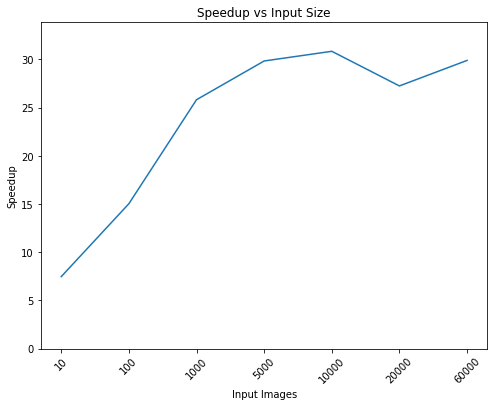

In [ ]:
speedup = [seq / pall for (seq, pall) in zip(times_cpu_32, times_gpu_32)]
max_speedup = np.max(speedup)
print("Max Speedup obtained", max_speedup)
x_ticks = [i for i in range(1,len(speedup)+1)]
plt.figure(figsize=(8,6))
plt.plot(x_ticks, speedup)
plt.xticks(x_ticks, INP_SIZES, rotation='45')

plt.ylabel('Speedup')
plt.xlabel('Input Images')
plt.ylim(0, max_speedup+3)
plt.title('Speedup vs Input Size')
plt.savefig('speedup_inputsize', dpi=300)


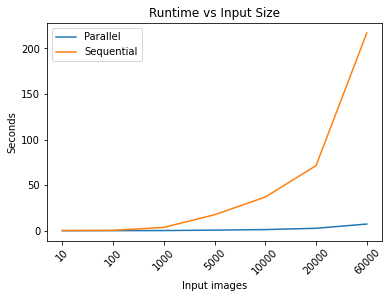

In [ ]:
plt.clf()
plt.plot(x_ticks, times_gpu_32, label="Parallel")
plt.plot(x_ticks, times_cpu_32, label="Sequential")
plt.xticks(x_ticks, INP_SIZES, rotation='45')
plt.xlabel("Input images")
plt.ylabel("Seconds")
plt.legend()
plt.title("Runtime vs Input Size")

plt.savefig("runtime_inputsize", dpi=300)

###Pooling (Correctness) CPU vs GPU

In [ ]:
# --- SETUP
X_data = normalTrainX[:,None,:,:]    # (60000, 1, 28, 28)
# _X_data = X_data[:10] # testing

N, C, H, W = X_data.shape
K = 2
H_out = H - K + 1
W_out = W - K + 1
M = 1

# --- CPU SETUP
# Allocate for Y
Y_cpu = np.zeros((N, M, H_out, W_out))
pool_cpu = Pooling_CPU(bs=N, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)

# --- GPU SETUP
Y_gpu = np.zeros((N, M, H_out, W_out))
#conv_gpu = Convolution_GPU(bs=N, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)
#conv_gpu.weights = conv_cpu.weights.copy()
pool_gpu = Pooling_GPU(bs=N, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)

In [ ]:
# --- START TIMER
tic = time.perf_counter()

# --- Forward Pass
pool_cpu.forward(X_data, Y_cpu)
print(Y_cpu)

# --- STOP TIMER
toc = time.perf_counter()
# --- PRINT TIMER
exec_time_cpu = toc - tic
print(f"[Sequential, tiled execution finished in {exec_time_cpu:0.5f} seconds]")

# --- START TIMER
tic = time.perf_counter()

# --- Forward Pass
pool_gpu.forward(X_data, Y_gpu)
print(Y_gpu)

# --- STOP TIMER
toc = time.perf_counter()
# --- PRINT TIMER
exec_time_gpu = toc - tic
print(f"[Parallel, tiled execution finished in {exec_time_gpu:0.5f} seconds]")

# Compute Average Element-wise Difference
MeanDiff = elemWiseDiff(Y_cpu, Y_gpu) / Y_cpu.size
MeanDiff

Observations:   0%|          | 0/60000 [00:00<?, ?it/s]

[[[[-1.         -1.         -1.         ...  0.          0.
     0.        ]
   [-1.         -1.         -1.         ...  0.          0.
     0.        ]
   [-1.         -1.         -1.         ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]]


 [[[-1.         -0.99803922 -0.99803922 ...  0.          0.
     0.        ]
   [-1.         -1.         -0.60392157 ...  0.          0.
     0.        ]
   [-1.         -1.          0.2        ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]]


 [[[-1.         -1.         -1.         ...  0.       

0.0

###Pooling Layer Results + Plots

####Speedup with Block Size 16

In [ ]:
MAX_N = normalTrainX.shape[0]
INP_SIZES = [10, 100, 1000, 5000, 10000, 20000, 60000]
X = normalTrainX[:,None,:,:]

times_cpu = []
times_gpu = []

for input_size in INP_SIZES:
    print("=> Input size", input_size)
    subset_X = X[:input_size]     # (size, 1, 28, 28)
    # Setup
    N, C, H, W = subset_X.shape
    K = 2
    H_out = H - K + 1
    W_out = W - K + 1
    M = 1
    # --- SETUP
    Y_cpu = np.zeros((input_size, M, H_out, W_out))
    Y_gpu = np.zeros((input_size, M, H_out, W_out))
    pool_cpu = Pooling_CPU(bs=input_size, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)
    pool_gpu = Pooling_GPU(bs=input_size, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)
    

    # CPU
    # --- START TIMER
    tic = time.perf_counter()

    # --- Forward Pass
    pool_cpu.forward(subset_X, Y_cpu)
    # --- STOP TIMER
    toc = time.perf_counter()
    # --- PRINT TIMER
    exec_time_cpu = toc - tic

    # GPU
    # --- START TIMER
    tic_ = time.perf_counter()
    # --- Forward Pass
    pool_gpu.forward(subset_X, Y_gpu)

    # --- STOP TIMER
    toc_ = time.perf_counter()
    # --- PRINT TIMER
    exec_time_gpu = toc_ - tic_

    times_cpu.append(exec_time_cpu)
    times_gpu.append(exec_time_gpu)
    print("finished\t", "(cpu)",exec_time_cpu,"\t(gpu)", exec_time_gpu)
    print("Mean Element wise Delta in Y results", elemWiseDiff(Y_cpu, Y_gpu) / (Y_cpu.size))


=> Input size 10


Observations:   0%|          | 0/10 [00:00<?, ?it/s]

finished	 (cpu) 0.05784293799933948 	(gpu) 0.008790243000476039
Mean Element wise Delta in Y results 0.0
=> Input size 100


Observations:   0%|          | 0/100 [00:00<?, ?it/s]

finished	 (cpu) 0.14898061099938786 	(gpu) 0.02468795200002205
Mean Element wise Delta in Y results 0.0
=> Input size 1000


Observations:   0%|          | 0/1000 [00:00<?, ?it/s]

finished	 (cpu) 1.0712877579999258 	(gpu) 0.13548019299923908
Mean Element wise Delta in Y results 0.0
=> Input size 5000


Observations:   0%|          | 0/5000 [00:00<?, ?it/s]

finished	 (cpu) 5.191664893999587 	(gpu) 0.6406037599999763
Mean Element wise Delta in Y results 0.0
=> Input size 10000


Observations:   0%|          | 0/10000 [00:00<?, ?it/s]

finished	 (cpu) 10.307505036000293 	(gpu) 1.2785100239998428
Mean Element wise Delta in Y results 0.0
=> Input size 20000


Observations:   0%|          | 0/20000 [00:00<?, ?it/s]

finished	 (cpu) 20.396307138999873 	(gpu) 2.4907800870005303
Mean Element wise Delta in Y results 0.0
=> Input size 60000


Observations:   0%|          | 0/60000 [00:00<?, ?it/s]

finished	 (cpu) 61.41653408899947 	(gpu) 7.6542332210001405
Mean Element wise Delta in Y results 0.0


Max Speedup obtained 8.188722579503876


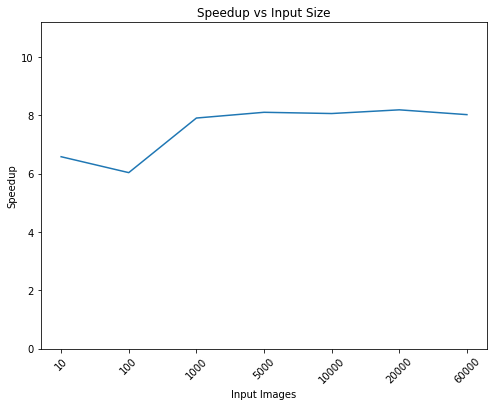

In [ ]:
speedup = [seq / pall for (seq, pall) in zip(times_cpu, times_gpu)]
max_speedup = np.max(speedup)
print("Max Speedup obtained", max_speedup)
x_ticks = [i for i in range(1,len(speedup)+1)]
plt.figure(figsize=(8,6))
plt.plot(x_ticks, speedup)
plt.xticks(x_ticks, INP_SIZES, rotation='45')

plt.ylabel('Speedup')
plt.xlabel('Input Images')
plt.ylim(0, max_speedup+3)
plt.title('Speedup vs Input Size')
plt.savefig('speedup_inputsize', dpi=300)

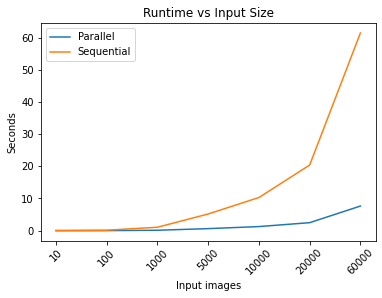

In [ ]:
plt.plot(x_ticks, times_gpu, label="Parallel")
plt.plot(x_ticks, times_cpu, label="Sequential")
plt.xticks(x_ticks, INP_SIZES, rotation='45')
plt.xlabel("Input images")
plt.ylabel("Seconds")
plt.legend()
plt.title("Runtime vs Input Size")

plt.savefig("runtime_inputsize", dpi=300)

####Speedup with Block Size 24

In [ ]:
MAX_N = normalTrainX.shape[0]
INP_SIZES = [10, 100, 1000, 5000, 10000, 20000, 60000]
X = normalTrainX[:,None,:,:]
TILE_SIZE = 24

times_cpu_24 = []
times_gpu_24 = []

for input_size in INP_SIZES:
    print("=> Input size", input_size)
    subset_X = X[:input_size]     # (size, 1, 28, 28)
    # Setup
    N, C, H, W = subset_X.shape
    K = 2
    H_out = H - K + 1
    W_out = W - K + 1
    M = 1
    # --- SETUP
    Y_cpu = np.zeros((input_size, M, H_out, W_out))
    Y_gpu = np.zeros((input_size, M, H_out, W_out))
    pool_cpu = Pooling_CPU(bs=input_size, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)
    pool_gpu = Pooling_GPU(bs=input_size, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)
    
    pool_gpu.setTileSize(TILE_SIZE)

    # CPU
    # --- START TIMER
    tic = time.perf_counter()

    # --- Forward Pass
    pool_cpu.forward(subset_X, Y_cpu)
    # --- STOP TIMER
    toc = time.perf_counter()
    # --- PRINT TIMER
    exec_time_cpu = toc - tic

    # GPU
    # --- START TIMER
    tic_ = time.perf_counter()
    # --- Forward Pass
    pool_gpu.forward(subset_X, Y_gpu)

    # --- STOP TIMER
    toc_ = time.perf_counter()
    # --- PRINT TIMER
    exec_time_gpu = toc_ - tic_

    times_cpu_24.append(exec_time_cpu)
    times_gpu_24.append(exec_time_gpu)
    print("finished\t", "(cpu)",exec_time_cpu,"\t(gpu)", exec_time_gpu)
    print("Mean Element wise Delta in Y results", elemWiseDiff(Y_cpu, Y_gpu) / (Y_cpu.size))

=> Input size 10


Observations:   0%|          | 0/10 [00:00<?, ?it/s]

finished	 (cpu) 0.060954607999519794 	(gpu) 0.007345412000177021
Mean Element wise Delta in Y results 0.0
=> Input size 100


Observations:   0%|          | 0/100 [00:00<?, ?it/s]

finished	 (cpu) 0.14350969399947644 	(gpu) 0.020065323999915563
Mean Element wise Delta in Y results 0.0
=> Input size 1000


Observations:   0%|          | 0/1000 [00:00<?, ?it/s]

finished	 (cpu) 1.1153954709998288 	(gpu) 0.13981995899939648
Mean Element wise Delta in Y results 0.0
=> Input size 5000


Observations:   0%|          | 0/5000 [00:00<?, ?it/s]

finished	 (cpu) 5.178951042000335 	(gpu) 0.6667010589999336
Mean Element wise Delta in Y results 0.0
=> Input size 10000


Observations:   0%|          | 0/10000 [00:00<?, ?it/s]

finished	 (cpu) 10.144527194999682 	(gpu) 1.2537015929992776
Mean Element wise Delta in Y results 0.0
=> Input size 20000


Observations:   0%|          | 0/20000 [00:00<?, ?it/s]

finished	 (cpu) 20.080643968000004 	(gpu) 2.4868865799999185
Mean Element wise Delta in Y results 0.0
=> Input size 60000


Observations:   0%|          | 0/60000 [00:00<?, ?it/s]

finished	 (cpu) 62.19653128200025 	(gpu) 7.635473714
Mean Element wise Delta in Y results 0.0


Max Speedup obtained 8.591206680484447


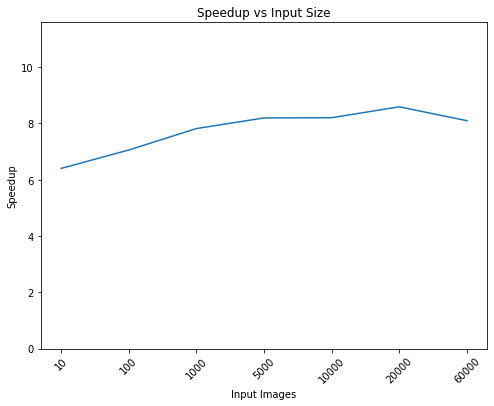

In [ ]:
speedup = [seq / pall for (seq, pall) in zip(times_cpu, times_gpu)]
max_speedup = np.max(speedup)
print("Max Speedup obtained", max_speedup)
x_ticks = [i for i in range(1,len(speedup)+1)]
plt.figure(figsize=(8,6))
plt.plot(x_ticks, speedup)
plt.xticks(x_ticks, INP_SIZES, rotation='45')

plt.ylabel('Speedup')
plt.xlabel('Input Images')
plt.ylim(0, max_speedup+3)
plt.title('Speedup vs Input Size')
plt.savefig('speedup_inputsize', dpi=300)

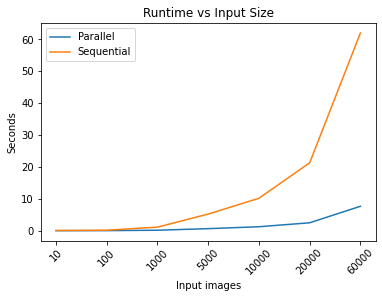

In [ ]:
plt.plot(x_ticks, times_gpu, label="Parallel")
plt.plot(x_ticks, times_cpu, label="Sequential")
plt.xticks(x_ticks, INP_SIZES, rotation='45')
plt.xlabel("Input images")
plt.ylabel("Seconds")
plt.legend()
plt.title("Runtime vs Input Size")

plt.savefig("runtime_inputsize", dpi=300)

####Speedup with Block Size 32

In [ ]:
MAX_N = normalTrainX.shape[0]
INP_SIZES = [10, 100, 1000, 5000, 10000, 20000, 60000]
X = normalTrainX[:,None,:,:]
TILE_SIZE = 32

times_cpu_32 = []
times_gpu_32 = []

for input_size in INP_SIZES:
    print("=> Input size", input_size)
    subset_X = X[:input_size]     # (size, 1, 28, 28)
    # Setup
    N, C, H, W = subset_X.shape
    K = 2
    H_out = H - K + 1
    W_out = W - K + 1
    M = 1
    # --- SETUP
    Y_cpu = np.zeros((input_size, M, H_out, W_out))
    Y_gpu = np.zeros((input_size, M, H_out, W_out))
    pool_cpu = Pooling_CPU(bs=input_size, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)
    pool_gpu = Pooling_GPU(bs=input_size, n_in=C, n_out=M, k=K, h=H, w=W, flat=False)
    
    pool_gpu.setTileSize(TILE_SIZE)

    # CPU
    # --- START TIMER
    tic = time.perf_counter()

    # --- Forward Pass
    pool_cpu.forward(subset_X, Y_cpu)
    # --- STOP TIMER
    toc = time.perf_counter()
    # --- PRINT TIMER
    exec_time_cpu = toc - tic

    # GPU
    # --- START TIMER
    tic_ = time.perf_counter()
    # --- Forward Pass
    pool_gpu.forward(subset_X, Y_gpu)

    # --- STOP TIMER
    toc_ = time.perf_counter()
    # --- PRINT TIMER
    exec_time_gpu = toc_ - tic_

    times_cpu_32.append(exec_time_cpu)
    times_gpu_32.append(exec_time_gpu)
    print("finished\t", "(cpu)",exec_time_cpu,"\t(gpu)", exec_time_gpu)
    print("Mean Element wise Delta in Y results", elemWiseDiff(Y_cpu, Y_gpu) / (Y_cpu.size))

=> Input size 10


Observations:   0%|          | 0/10 [00:00<?, ?it/s]

finished	 (cpu) 0.047235032000571664 	(gpu) 0.009889210000437743
Mean Element wise Delta in Y results 0.0
=> Input size 100


Observations:   0%|          | 0/100 [00:00<?, ?it/s]

finished	 (cpu) 0.17182122799931676 	(gpu) 0.02369413800079201
Mean Element wise Delta in Y results 0.0
=> Input size 1000


Observations:   0%|          | 0/1000 [00:00<?, ?it/s]

finished	 (cpu) 1.671922694999921 	(gpu) 0.3536809609995544
Mean Element wise Delta in Y results 0.0
=> Input size 5000


Observations:   0%|          | 0/5000 [00:00<?, ?it/s]

finished	 (cpu) 5.191674986999715 	(gpu) 0.6771784270003991
Mean Element wise Delta in Y results 0.0
=> Input size 10000


Observations:   0%|          | 0/10000 [00:00<?, ?it/s]

finished	 (cpu) 10.171760481000092 	(gpu) 1.2439629400005288
Mean Element wise Delta in Y results 0.0
=> Input size 20000


Observations:   0%|          | 0/20000 [00:00<?, ?it/s]

finished	 (cpu) 20.305984356999943 	(gpu) 2.452242127000318
Mean Element wise Delta in Y results 0.0
=> Input size 60000


Observations:   0%|          | 0/60000 [00:00<?, ?it/s]

finished	 (cpu) 60.023407960999975 	(gpu) 8.752310344000762
Mean Element wise Delta in Y results 0.0


Max Speedup obtained 8.188722579503876


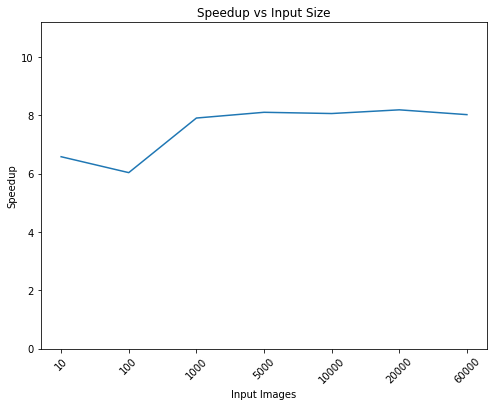

In [ ]:
speedup = [seq / pall for (seq, pall) in zip(times_cpu, times_gpu)]
max_speedup = np.max(speedup)
print("Max Speedup obtained", max_speedup)
x_ticks = [i for i in range(1,len(speedup)+1)]
plt.figure(figsize=(8,6))
plt.plot(x_ticks, speedup)
plt.xticks(x_ticks, INP_SIZES, rotation='45')

plt.ylabel('Speedup')
plt.xlabel('Input Images')
plt.ylim(0, max_speedup+3)
plt.title('Speedup vs Input Size')
plt.savefig('speedup_inputsize', dpi=300)

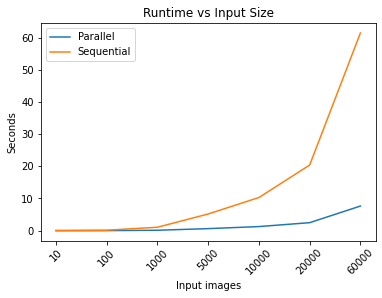

In [ ]:
plt.plot(x_ticks, times_gpu, label="Parallel")
plt.plot(x_ticks, times_cpu, label="Sequential")
plt.xticks(x_ticks, INP_SIZES, rotation='45')
plt.xlabel("Input images")
plt.ylabel("Seconds")
plt.legend()
plt.title("Runtime vs Input Size")

plt.savefig("runtime_inputsize", dpi=300)

### Linear (correctness) CPU vs GPU 

In [ ]:
# --- SETUP
# Flatten every 28x28 into 784
bs = 10
trainX = normalTrainX[:bs,:,:].reshape(bs*28*28)
print("Linear Layer inputs shape", trainX.shape)

n_in = 28*28
n_out = 32

# Linearized matrix lengths
in_size = bs * n_in
out_size = bs * n_out
weights_size = n_in * n_out

Y_cpu = np.zeros(out_size)
Y_gpu = np.zeros(out_size)

# Init two models with equal weights
lin_cpu = Linear_CPU(bs, n_in, n_out)
lin_gpu = Linear_GPU(bs, n_in, n_out)

lin_gpu.weights = lin_cpu.weights.copy()

Linear Layer inputs shape (7840,)


In [ ]:
# --- START TIMER
tic = time.perf_counter()

lin_cpu.forward(trainX, Y_cpu)
# --- STOP TIMER
toc = time.perf_counter()
# --- PRINT TIMER
exec_time_cpu = toc - tic

# --- START TIMER
tic_ = time.perf_counter()

lin_gpu.forward(trainX, Y_gpu)
# --- STOP TIMER
toc_ = time.perf_counter()
# --- PRINT TIMER
exec_time_gpu = toc_ - tic_
print("finished\t", "(cpu)",exec_time_cpu,"\t(gpu)", exec_time_gpu)

elemWiseDiff(Y_cpu, Y_gpu)

finished	 (cpu) 0.2421493880000014 	(gpu) 1.180377558999993


0.0

### Linear Layer Results + plots

#### Block Size 16

In [ ]:
INP_SIZES = [10, 100, 1000, 5000, 10000, 20000, 60000]
n_in = 28*28
n_out = 32
weights_size = n_in * n_out

BLOCK_SIZE = 16

times_lin_cpu_16 = []
times_lin_gpu_16 = []

for input_size in INP_SIZES:
    # Subset the data
    bs = input_size
    trainX = normalTrainX[:bs,:,:].reshape(bs*28*28)
    print("Linear Layer inputs shape", trainX.shape)

    # Linearized matrix lengths
    in_size = bs * n_in
    out_size = bs * n_out

    Y_cpu = np.zeros(out_size)
    Y_gpu = np.zeros(out_size)

    # Init two models with equal weights
    lin_cpu = Linear_CPU(bs, n_in, n_out)
    lin_gpu = Linear_GPU(bs, n_in, n_out)

    lin_gpu.weights = lin_cpu.weights.copy()
    lin_gpu.setBlockSize(BLOCK_SIZE)

    # --- START TIMER
    tic = time.perf_counter()

    lin_cpu.forward(trainX, Y_cpu)
    # --- STOP TIMER
    toc = time.perf_counter()
    # --- PRINT TIMER
    exec_time_cpu = toc - tic

    # --- START TIMER
    tic_ = time.perf_counter()

    lin_gpu.forward(trainX, Y_gpu)
    # --- STOP TIMER
    toc_ = time.perf_counter()
    # --- PRINT TIMER
    exec_time_gpu = toc_ - tic_
    print("finished\t", "(cpu)",exec_time_cpu,"\t(gpu)", exec_time_gpu)
    times_lin_cpu_16.append(exec_time_cpu)
    times_lin_gpu_16.append(exec_time_gpu)

    print("Mean Element wise Delta in Y results", (elemWiseDiff(Y_cpu, Y_gpu) / (Y_cpu.size)))

Linear Layer inputs shape (7840,)
finished	 (cpu) 0.15535809500011055 	(gpu) 0.17734145200006424
Mean Element wise Delta in Y results 2.3644280977563883e-16
Linear Layer inputs shape (78400,)
finished	 (cpu) 1.5674344999999903 	(gpu) 0.0031935269998939475
Mean Element wise Delta in Y results 2.306835278353958e-16
Linear Layer inputs shape (784000,)
finished	 (cpu) 16.010519849000048 	(gpu) 0.011529955000014525
Mean Element wise Delta in Y results 2.344282537189435e-16
Linear Layer inputs shape (3920000,)
finished	 (cpu) 79.53408686900002 	(gpu) 0.04018591900012325
Mean Element wise Delta in Y results 2.366283262541201e-16
Linear Layer inputs shape (7840000,)
finished	 (cpu) 156.7166270849998 	(gpu) 0.07469722500036369
Mean Element wise Delta in Y results 2.2802853762117145e-16
Linear Layer inputs shape (15680000,)
finished	 (cpu) 313.47217556199985 	(gpu) 0.15039947900004336
Mean Element wise Delta in Y results 2.3060202852749667e-16
Linear Layer inputs shape (47040000,)
finished	 (cpu

Max speedup obtained 2411.0175394331563


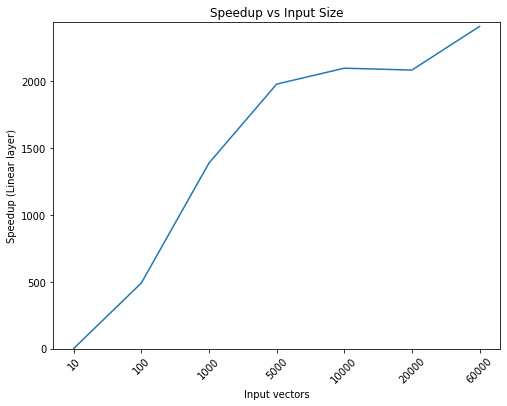

In [ ]:
speedup = [seq / pall for (seq, pall) in zip(times_lin_cpu_16, times_lin_gpu_16)]
max_speedup = np.max(speedup)
print("Max speedup obtained", max_speedup)
x_ticks = [i for i in range(1,len(speedup)+1)]
plt.figure(figsize=(8,6))
plt.plot(x_ticks, speedup)
plt.xticks(x_ticks, INP_SIZES, rotation='45')

plt.ylabel('Speedup (Linear layer)')
plt.xlabel('Input vectors')
plt.ylim(0, max_speedup+30)
plt.title('Speedup vs Input Size')
plt.savefig('speedup_inputsize_linear16', dpi=300)

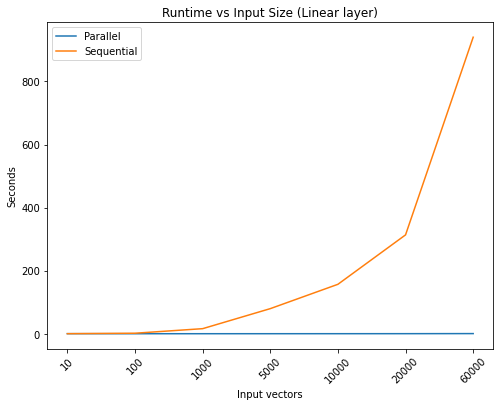

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(x_ticks, times_lin_gpu_16, label="Parallel")
plt.plot(x_ticks, times_lin_cpu_16, label="Sequential")
plt.title("Runtime vs Input Size (Linear layer)")
plt.xticks(x_ticks, INP_SIZES, rotation='45')
plt.xlabel("Input vectors")
plt.ylabel("Seconds")
plt.legend()

plt.savefig("runtime_inputsize_linear16", dpi=300)

In [ ]:
sp16 = [seq / pall for (seq, pall) in zip(times_lin_cpu_16, times_lin_gpu_16)]
sp16

[0.8760393762878083,
 490.81611022923636,
 1388.6021106743156,
 1979.1531175075552,
 2098.0247537205937,
 2084.2637065379026,
 2411.0175394331563]

#### Block Size 24

In [ ]:
INP_SIZES = [10, 100, 1000, 5000, 10000, 20000, 60000]
n_in = 28*28
n_out = 32
weights_size = n_in * n_out

BLOCK_SIZE = 24

times_lin_cpu_24 = []
times_lin_gpu_24 = []

for input_size in INP_SIZES:
    # Subset the data
    bs = input_size
    trainX = normalTrainX[:bs,:,:].reshape(bs*28*28)
    print("Linear Layer inputs shape", trainX.shape)

    # Linearized matrix lengths
    in_size = bs * n_in
    out_size = bs * n_out

    Y_cpu = np.zeros(out_size)
    Y_gpu = np.zeros(out_size)

    # Init two models with equal weights
    lin_cpu = Linear_CPU(bs, n_in, n_out)
    lin_gpu = Linear_GPU(bs, n_in, n_out)

    lin_gpu.weights = lin_cpu.weights.copy()
    lin_gpu.setBlockSize(BLOCK_SIZE)

    # --- START TIMER
    tic = time.perf_counter()

    lin_cpu.forward(trainX, Y_cpu)
    # --- STOP TIMER
    toc = time.perf_counter()
    # --- PRINT TIMER
    exec_time_cpu = toc - tic

    # --- START TIMER
    tic_ = time.perf_counter()

    lin_gpu.forward(trainX, Y_gpu)
    # --- STOP TIMER
    toc_ = time.perf_counter()
    # --- PRINT TIMER
    exec_time_gpu = toc_ - tic_
    print("finished\t", "(cpu)",exec_time_cpu,"\t(gpu)", exec_time_gpu)
    times_lin_cpu_24.append(exec_time_cpu)
    times_lin_gpu_24.append(exec_time_gpu)

    print("Sum of element wise difference in output:", elemWiseDiff(Y_cpu, Y_gpu))

Linear Layer inputs shape (7840,)
finished	 (cpu) 0.16639533099987602 	(gpu) 0.0037648590000571858
Sum of element wise difference in output: 8.110179194886769e-14
Linear Layer inputs shape (78400,)
finished	 (cpu) 1.6529852259996005 	(gpu) 0.006287836999945284
Sum of element wise difference in output: 7.484499131571454e-13
Linear Layer inputs shape (784000,)
finished	 (cpu) 15.957496091999928 	(gpu) 0.011334092999732093
Sum of element wise difference in output: 7.2752403060261095e-12
Linear Layer inputs shape (3920000,)
finished	 (cpu) 78.61620759000016 	(gpu) 0.03953491900028894
Sum of element wise difference in output: 3.547926774420673e-11
Linear Layer inputs shape (7840000,)
finished	 (cpu) 155.56486136400008 	(gpu) 0.07683545999998387
Sum of element wise difference in output: 7.285403140142033e-11
Linear Layer inputs shape (15680000,)
finished	 (cpu) 311.71790463499974 	(gpu) 0.14567934299975605
Sum of element wise difference in output: 1.4098787718894168e-10
Linear Layer inputs s

Max speedup obtained 2249.707955683805


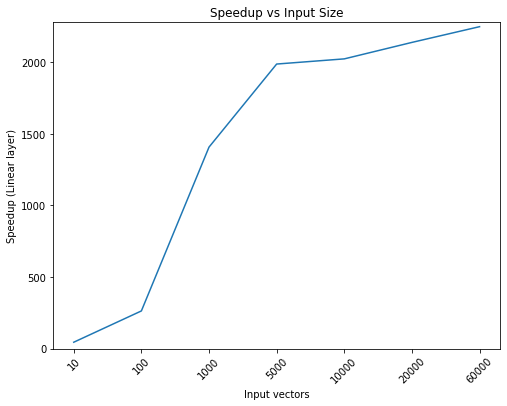

In [ ]:
speedup = [seq / pall for (seq, pall) in zip(times_lin_cpu_24, times_lin_gpu_24)]
max_speedup = np.max(speedup)
print("Max speedup obtained", max_speedup)
x_ticks = [i for i in range(1,len(speedup)+1)]
plt.figure(figsize=(8,6))
plt.plot(x_ticks, speedup)
plt.xticks(x_ticks, INP_SIZES, rotation='45')

plt.ylabel('Speedup (Linear layer)')
plt.xlabel('Input vectors')
plt.ylim(0, max_speedup+30)
plt.title('Speedup vs Input Size')
plt.savefig('speedup_inputsize_linear24', dpi=300)

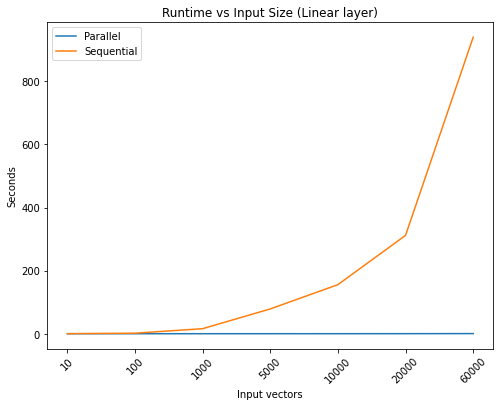

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(x_ticks, times_lin_gpu_24, label="Parallel")
plt.plot(x_ticks, times_lin_cpu_24, label="Sequential")
plt.title("Runtime vs Input Size (Linear layer)")
plt.xticks(x_ticks, INP_SIZES, rotation='45')
plt.xlabel("Input vectors")
plt.ylabel("Seconds")
plt.legend()

plt.savefig("runtime_inputsize_linear24", dpi=300)

In [ ]:
sp24 = [seq / pall for (seq, pall) in zip(times_lin_cpu_24, times_lin_gpu_24)]
sp24

[44.19696222284781,
 262.88614447448055,
 1407.9199890434215,
 1988.5258292656574,
 2024.649313793823,
 2139.7536412250415,
 2249.707955683805]

#### Block Size 32

In [ ]:
INP_SIZES = [10, 100, 1000, 5000, 10000, 20000, 60000]
n_in = 28*28
n_out = 32
weights_size = n_in * n_out

times_lin_cpu = []
times_lin_gpu = []

for input_size in INP_SIZES:
    # Subset the data
    bs = input_size
    trainX = normalTrainX[:bs,:,:].reshape(bs*28*28)
    print("Linear Layer inputs shape", trainX.shape)

    # Linearized matrix lengths
    in_size = bs * n_in
    out_size = bs * n_out

    Y_cpu = np.zeros(out_size)
    Y_gpu = np.zeros(out_size)

    # Init two models with equal weights
    lin_cpu = Linear_CPU(bs, n_in, n_out)
    lin_gpu = Linear_GPU(bs, n_in, n_out)

    lin_gpu.weights = lin_cpu.weights.copy()

    # --- START TIMER
    tic = time.perf_counter()

    lin_cpu.forward(trainX, Y_cpu)
    # --- STOP TIMER
    toc = time.perf_counter()
    # --- PRINT TIMER
    exec_time_cpu = toc - tic

    # --- START TIMER
    tic_ = time.perf_counter()

    lin_gpu.forward(trainX, Y_gpu)
    # --- STOP TIMER
    toc_ = time.perf_counter()
    # --- PRINT TIMER
    exec_time_gpu = toc_ - tic_
    print("finished\t", "(cpu)",exec_time_cpu,"\t(gpu)", exec_time_gpu)
    times_lin_cpu.append(exec_time_cpu)
    times_lin_gpu.append(exec_time_gpu)

    print("Sum of element wise difference in output:", elemWiseDiff(Y_cpu, Y_gpu))

Linear Layer inputs shape (7840,)
finished	 (cpu) 0.15978676799932146 	(gpu) 0.0028801270000258228
Sum of element wise difference in output: 7.928380174604399e-14
Linear Layer inputs shape (78400,)
finished	 (cpu) 1.66684966000048 	(gpu) 0.005924377999690478
Sum of element wise difference in output: 7.275291480368651e-13
Linear Layer inputs shape (784000,)
finished	 (cpu) 15.943858339000144 	(gpu) 0.013923505999628105
Sum of element wise difference in output: 7.203909344055681e-12
Linear Layer inputs shape (3920000,)
finished	 (cpu) 77.16853824000009 	(gpu) 0.04132319600012124
Sum of element wise difference in output: 3.8292637290215925e-11
Linear Layer inputs shape (7840000,)
finished	 (cpu) 164.50559274699935 	(gpu) 0.08014876000015647
Sum of element wise difference in output: 7.119241231690748e-11
Linear Layer inputs shape (15680000,)
finished	 (cpu) 312.80791086299996 	(gpu) 0.16313521500069328
Sum of element wise difference in output: 1.5294997581828673e-10
Linear Layer inputs sha

Max speedup obtained 2448.495527724039


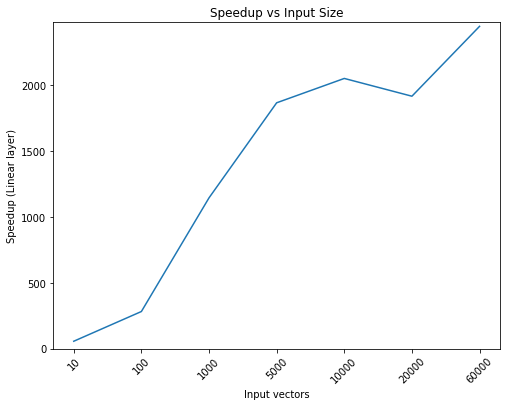

In [ ]:
speedup = [seq / pall for (seq, pall) in zip(times_lin_cpu, times_lin_gpu)]
max_speedup = np.max(speedup)
print("Max speedup obtained", max_speedup)
x_ticks = [i for i in range(1,len(speedup)+1)]
plt.figure(figsize=(8,6))
plt.plot(x_ticks, speedup)
plt.xticks(x_ticks, INP_SIZES, rotation='45')

plt.ylabel('Speedup (Linear layer)')
plt.xlabel('Input vectors')
plt.ylim(0, max_speedup+30)
plt.title('Speedup vs Input Size')
plt.savefig('speedup_inputsize_linear32', dpi=300)

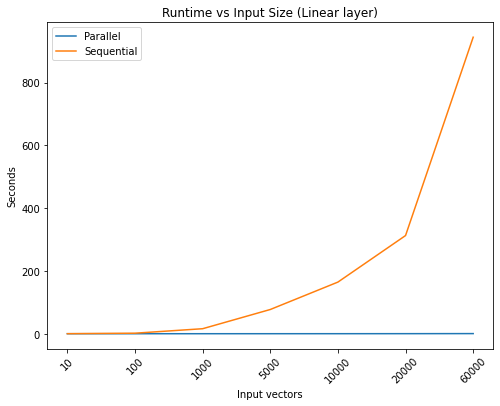

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(x_ticks, times_lin_gpu, label="Parallel")
plt.plot(x_ticks, times_lin_cpu, label="Sequential")
plt.title("Runtime vs Input Size (Linear layer)")
plt.xticks(x_ticks, INP_SIZES, rotation='45')
plt.xlabel("Input vectors")
plt.ylabel("Seconds")
plt.legend()

plt.savefig("runtime_inputsize_linear32", dpi=300)

In [ ]:
sp = [seq / pall for (seq, pall) in zip(times_lin_cpu, times_lin_gpu)]
sp

[55.47907019304664,
 281.3543734190434,
 1145.103707315241,
 1867.4387682834038,
 2052.5032794852746,
 1917.4763147348083,
 2448.495527724039]

# Unit Tests

### Single Update

In [ ]:
### EXAMPLE SNIPPET FOR CPU ### 
bs = 10
n_in = 5
n_out = 1
out_size = bs * n_out
X = np.random.normal(loc=0, scale=1, size=bs*n_in)
Y = np.zeros(bs*n_out)

target = np.array([1,0,1,1,1,0,1,0,0,1])

lin = Linear_CPU(bs, n_in, n_out)
relu = ReLU_CPU(out_size)
layers =[lin, relu]

seq = Sequential_CPU(layers)
loss = MSE_CPU(bs)

seq.forward(X, Y)
loss.forward(seq.layers[-1].out, target)

loss.backward() # compute gradient from Loss
seq.update()

size weights 5
linear.forward()
Linear X shape (forward) (50,)
Linear weights shape (forward) (5,)
Linear bias shape (forward) (1,)
Linear Y shape (forward) (10,)
linear.update()
Linear weights shape (update) (5,)
Linear cp_weights shape (update) (5,)
linear_update shapes:
bias (backward) (1,)
weights (backward) (5,)
out Y (backward) (10,)
X (backward) (50,)
self.n_out 1
n_out 1

linear.backward()
X shape (50,)
cp weights shape (5,)
Y shape (10,)


### Linear Layer Test

In [ ]:
# Random architecture
bs = np.random.randint(32, 256+1)
n_in = np.random.randint(32, 64+1)
n_out = 1 # np.random.randint(1, 32+1)

# Linearized matrix lengths
in_size = bs * n_in
out_size = bs * n_out
weights_size = n_in * n_out

# Init two data sets 
X_cpu = np.random.normal(loc=0, scale=1, size=in_size)
X_gpu = X_cpu.copy()
Y_cpu = np.zeros(out_size)
Y_gpu = np.zeros(out_size)

# Init two models with equal weights
lin_cpu = Linear_CPU(bs, n_in, n_out)
lin_gpu = Linear_GPU(bs, n_in, n_out)

lin_gpu.weights = lin_cpu.weights.copy()

size weights 52


In [ ]:
print("w[0]", lin_gpu.weights[0])
print("w[0]", lin_cpu.weights[0])

w[0] -0.02528684389519028
w[0] -0.02528684389519028


In [ ]:
lin_cpu.forward(X_cpu, Y_cpu)
lin_gpu.forward(X_gpu, Y_gpu)
elemWiseDiff(Y_cpu, Y_gpu)

linear.forward()
Linear X shape (forward) (8996,)
Linear weights shape (forward) (52,)
Linear bias shape (forward) (1,)
Linear Y shape (forward) (173,)


0.0

In [ ]:
Y_cpu[:5], Y_gpu[:5]

(array([-0.8195145 ,  0.12289906, -2.23440752, -0.87307082,  0.80709727]),
 array([-0.8195145 ,  0.12289906, -2.23440752, -0.87307082,  0.80709727]))

In [ ]:
# print("Weights cpu")
# print(lin_cpu.weights[:5])
# print("Weights gpu")
# print(lin_gpu.weights[:5])

lin_cpu.update()
lin_gpu.update()

print("--After update diff")
print("Weights cpu")
print(lin_cpu.weights[:5])
print("Weights gpu")
print(lin_gpu.weights[:5])
print("Element wise diff")
elemWiseDiff(lin_cpu.weights, lin_gpu.weights)

print("Bias cpu")
print(lin_cpu.bias[:5])
print("Bias gpu")
print(lin_gpu.bias[:5])
print("Element wise diff")
elemWiseDiff(lin_cpu.bias, lin_gpu.bias)

linear.update()
Linear weights shape (update) (52,)
Linear cp_weights shape (update) (52,)
linear_update shapes:
bias (backward) (1,)
weights (backward) (52,)
out Y (backward) (173,)
X (backward) (8996,)
self.n_out 1
n_out 1

--After update diff
Weights cpu
[ 0.33080514 -4.56646633  1.50599342 -3.98788464 -3.22963481]
Weights gpu
[ 0.33080514 -4.56646633  1.50599342 -3.98788464 -3.22963481]
Element wise diff
Bias cpu
[1.10808257]
Bias gpu
[1.10808257]
Element wise diff


0.0

In [ ]:
print("Before backward")
print("X cpu", lin_cpu.X.shape)
print(lin_cpu.X[:5])
print("X gpu", lin_gpu.X.shape)
print(lin_gpu.X[:5])

Before backward
X cpu (8996,)
[-2.02220122 -1.72908882 -0.24407447  0.19307961  1.24779637]
X gpu (8996,)
[-2.02220122 -1.72908882 -0.24407447  0.19307961  1.24779637]


In [ ]:
lin_cpu.backward()
lin_gpu.backward()
print("--After backward")
print("X input cpu", lin_cpu.X.shape)
print(lin_cpu.X[:5])
print("X input gpu", lin_gpu.X.shape)
print(lin_gpu.X[:5])

print("Element wise diff")
elemWiseDiff(lin_cpu.X, lin_gpu.X)

linear.backward()
X shape (8996,)
cp weights shape (52,)
Y shape (173,)
--After backward
X input cpu (8996,)
[ 0.02072294 -0.28268513  0.04376338 -0.14125916  0.00249962]
X input gpu (8996,)
[ 0.02072294 -0.28268513  0.04376338 -0.14125916  0.00249962]
Element wise diff


0.0

In [ ]:
# For a linear layer test LOOP, look at 
# https://medium.datadriveninvestor.com/implementing-a-neural-net-in-cuda-from-scratch-part-5-testing-5beea4fb6d53

### ReLU Layer Test

In [ ]:
bs = np.random.randint(128, 2048+1)
X_cpu = np.random.normal(loc=0, scale=1, size=bs)
Y_cpu = np.zeros(bs)
X_gpu = X_cpu.copy()
Y_gpu = np.zeros(bs)

print("Input X")
print(X_cpu[:5], X_gpu[:5])

# Create ReLU
relu_cpu = ReLU_CPU(bs)
relu_gpu = ReLU_GPU(bs)


relu_cpu.forward(X_cpu, Y_cpu)
relu_gpu.forward(X_gpu, Y_gpu)

print("Forward pass diff in Y results")
print(elemWiseDiff(Y_cpu, Y_gpu))

relu_cpu.backward()
relu_gpu.backward()
print("Backward pass diff in X results (gradient")
print(elemWiseDiff(relu_cpu.X, relu_gpu.X))
relu_cpu.X[:5], relu_gpu.X[:5]

Input X
[ 1.10897595 -0.30157082 -0.76130126  0.57422928 -1.13282653] [ 1.10897595 -0.30157082 -0.76130126  0.57422928 -1.13282653]
Forward pass diff in Y results
0.0
Backward pass diff in X results (gradient
0.0


(array([1., 0., 0., 1., 0.]), array([1., 0., 0., 1., 0.]))

#### MSE Layer test

In [ ]:
pre = np.array([1,2,3,4,5,6,7,8,9,10])
tru = np.array([2,0,4,2,6,4,8,6,10,8,.77])

((pre-tru[:10])**2).mean()

2.5

In [ ]:
bs = 10 # np.random.randint(32, 2048+1)

X_cpu = np.random.normal(loc=0, scale=1, size=bs)
X_gpu = X_cpu.copy()

Y_cpu = np.random.normal(loc=0, scale=1, size=bs+1)
Y_gpu = Y_cpu.copy()

mse_cpu = MSE_CPU(bs)
mse_gpu = MSE_GPU(bs)

# Store references
mse_cpu.forward(X_cpu, Y_cpu)
mse_gpu.forward(X_gpu, Y_gpu)

# Compute Loss
mse_cpu._forward()
mse_gpu._forward()

print("Forward pass")
print("CPU result", Y_cpu[bs])
print("GPU result", Y_gpu[bs])

# Backward pass results go in X array
mse_cpu.backward()
mse_gpu.backward()

print("Backward pass")
print("CPU result", X_cpu[:6])
print("GPU result", X_gpu[:6])

elemWiseDiff(X_cpu, X_gpu)


Forward pass
CPU result 2.3867083498533264
GPU result 2.3867083498533264
Backward pass
CPU result [ 0.37592945 -0.27787285  0.48781629  0.24198573 -0.07958726 -0.1073468 ]
GPU result [ 0.37592945 -0.27787285  0.48781629  0.24198573 -0.07958726 -0.1073468 ]


0.0

### Sequential Container Testing

Test for Linear + Relu activations, no convolution just yet

In [ ]:
# 1. Architecture
bs = np.random.randint(128, 2048+1)
n_in = np.random.randint(32, 64+1)
n_out = np.random.randint(1, 4+1)

# 2. Initialize input and output arrays
input_size = bs * n_in
weights_size = n_in * n_out
output_size = bs * n_out

# The output array we pass to the Sequential constructor is just there 
# for consistency but is not used
# Our final results are in last layer's .out array

X_cpu = np.random.normal(loc=0, scale=1, size=input_size)
X_gpu = X_cpu.copy()
dummy_Y = None

# 3. Setup the layers
'Step three is a tad bit more involved and includes some new material, but still nothing too complicated:'
# Lin layer
lin_cpu = Linear_CPU(bs, n_in, n_out)
lin_gpu = Linear_GPU(bs, n_in, n_out)

lin_gpu.weights = lin_cpu.weights.copy()

# Relu 
relu_cpu = ReLU_CPU(output_size)
relu_gpu = ReLU_CPU(output_size)

layers_cpu = [lin_cpu, relu_cpu]
layers_gpu = [lin_gpu, relu_gpu]

# Sequential
seq_cpu = Sequential_CPU(layers_cpu)
seq_gpu = Sequential_GPU(layers_gpu)

# Forward step
seq_cpu.forward(X_cpu, dummy_Y)
seq_gpu.forward(X_gpu, dummy_Y)

print("Seq forward pass results")
res_cpu = seq_cpu.out
print("CPU:", res_cpu[:5])
res_gpu = seq_gpu.out
print("GPU:", res_gpu[:5])

print(elemWiseDiff(res_cpu, res_gpu))

# Update step
seq_cpu.update()
seq_gpu.update()

print("Seq update() results")
# Weights, biases of linear layers should be updated
res_cpu_w = lin_cpu.weights
res_gpu_w = lin_gpu.weights
print("CPU weights:", res_cpu_w[:5])
print("GPU weights:", res_gpu_w[:5])
print(elemWiseDiff(res_cpu_w, res_gpu_w))

res_cpu_b = lin_cpu.bias
res_gpu_b = lin_gpu.bias
print("CPU biases:", res_cpu_b[:5])
print("GPU biases:", res_gpu_b[:5])

print(elemWiseDiff(res_cpu_b, res_gpu_b))

size weights 164
linear.forward()
Linear X shape (forward) (47560,)
Linear weights shape (forward) (164,)
Linear bias shape (forward) (4,)
Linear Y shape (forward) (4640,)
Seq forward pass results
CPU: [1.88241526 0.         0.97983341 0.00600811 0.        ]
GPU: [1.88241526 0.         0.97983341 0.00600811 0.        ]
0.0
linear.update()
Linear weights shape (update) (164,)
Linear cp_weights shape (update) (164,)
linear_update shapes:
bias (backward) (4,)
weights (backward) (164,)
out Y (backward) (4640,)
X (backward) (47560,)
self.n_out 4
n_out 4

linear.backward()
X shape (47560,)
cp weights shape (164,)
Y shape (4640,)
Seq update() results
CPU weights: [ 1.54046526 28.66603448 30.21539844 21.80281678 30.6107674 ]
GPU weights: [ 1.54046526 28.66603448 30.21539844 21.80281678 30.6107674 ]
4.354294702579864e-13
CPU biases: [-1.46996969  5.17037537  1.92228414  6.45793668]
GPU biases: [-1.46996969  5.17037537  1.92228414  6.45793668]
0.0
